# Models Creation

In [1]:
import cv2
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

2025-04-15 17:18:31.243947: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# Listar GPUs disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Asegúrate de que la GPU 1 existe
        print("GPUs disponibles:")
        for i, gpu in enumerate(gpus):
            print(f"GPU {i}: {gpu}")

        # Limitar visibilidad a solo la GPU 1
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

        # Establecer límite de memoria a 40 GB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=40960)]
        )

        print("Configuración de GPU establecida correctamente.")
    except RuntimeError as e:
        print("Error al configurar la GPU:", e)
else:
    print("No se encontraron GPUs disponibles.")

GPUs disponibles:
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Configuración de GPU establecida correctamente.


2025-04-15 17:18:32.056754: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-04-15 17:18:32.098971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-04-15 17:18:32.100236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:ae:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-04-15 17:18:32.100276: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-04-15 17:18:32.103296: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.

In [4]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
# Poner todas las seed en 42
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(".."))
from models.i3d import InceptionI3d, Logits

In [7]:
train_df = pd.read_csv("../data/ml/train.csv")
valid_df = pd.read_csv("../data/ml/valid.csv")
test_df = pd.read_csv("../data/ml/test.csv")


In [8]:
"""data = pd.read_csv("../data/ml/test.csv")
# Dividir el dataset en train (80%), valid (10%), test (10%)
train_df, test_valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['is_crime'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)"""

'data = pd.read_csv("../data/ml/test.csv")\n# Dividir el dataset en train (80%), valid (10%), test (10%)\ntrain_df, test_valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data[\'is_crime\'])\nvalid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)'

## Data Loader

In [9]:
from tensorflow.keras.utils import to_categorical
class VideoDataModule:
    def __init__(self, train_df, val_df, test_df, batch_size=8, frame_size=(224, 224), num_frames=32):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.num_frames = num_frames
        tf.random.set_seed(42)  # Establecer la semilla

    def _load_video_frames(self, video_path, start_frame, end_frame, training=False):
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Error: No se pudo abrir el video {video_path}")
            return None
        
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        start_frame = int(start_frame) if not np.isnan(start_frame) else 0
        end_frame = int(end_frame) if not np.isnan(end_frame) else total_frames
        
        # Chequear si el video tiene suficientes frames
        if end_frame - start_frame < self.num_frames:
            print(f"Advertencia: {video_path} tiene menos frames que los requeridos. Usando todo el video.")
        
        # Temporal offset aleatorio
        if training:
            # Ajustar máximo punto de inicio si hay menos frames disponibles que num_frames
            max_start = max(start_frame, end_frame - self.num_frames * max(1, (end_frame - start_frame) // self.num_frames))
            clip_start = np.random.randint(start_frame, max_start + 1)
        else:
            clip_start = start_frame
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, clip_start)

        step = max(1, (end_frame - start_frame) // self.num_frames)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = tf.convert_to_tensor(frame, dtype=tf.float32)

            if training:
                # Padding + random crop
                frame = tf.image.resize_with_crop_or_pad(frame, 240, 240)
                frame = tf.image.random_crop(frame, size=[*self.frame_size, 3])
                
                # Augmentaciones base
                frame = tf.image.random_flip_left_right(frame, seed=42)
                frame = tf.image.random_brightness(frame, max_delta=0.2, seed=42)
                frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2, seed=42)
                frame = tf.image.random_hue(frame, max_delta=0.05, seed=42)

                # Posibilidad de añadir ruido o blur
                if np.random.rand() < 0.2:
                    noise = tf.random.normal(shape=tf.shape(frame), mean=0.0, stddev=5.0)
                    frame = tf.clip_by_value(frame + noise, 0.0, 255.0)

                if np.random.rand() < 0.2:
                    # Blur usando OpenCV
                    frame = tf.cast(frame, tf.uint8).numpy()
                    frame = cv2.GaussianBlur(frame, (5, 5), 0)
                    frame = tf.convert_to_tensor(frame, dtype=tf.float32)

            else:
                # Normal resize para validación/test
                frame = tf.image.resize(frame, self.frame_size)

            # Normalización final
            frame = frame / 255.0
            frames.append(frame.numpy())

            for _ in range(step - 1):  # Saltar frames para ajustarse al total
                cap.read()

        cap.release()

        # Si faltan frames, completamos con ceros
        while len(frames) < self.num_frames:
            frames.append(np.zeros((*self.frame_size, 3)))

        return np.array(frames, dtype=np.float32)


    def _dataframe_to_tf_dataset(self, df, shuffle=True, training=False):
        file_paths = df["Path"].values
        start_frames = df["PCB"].values
        end_frames = df["End_Frame"].values
        labels = df["is_crime"].values.astype(np.float32)  # Convertir a float32

        def generator():
            for i in range(len(file_paths)):
                video_tensor = self._load_video_frames(file_paths[i], start_frames[i], end_frames[i], training)
                # Cambiamos la forma de la etiqueta para que sea (1,) en lugar de un escalar
                yield video_tensor, np.array([labels[i]], dtype=np.float32)

        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.num_frames, *self.frame_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(1,), dtype=tf.float32),  # Cambiado a (1,) en lugar de (2,)
            ),
        )

        if shuffle:
            dataset = dataset.shuffle(
                buffer_size=min(max(1000, len(df)//10), len(df)),  
                seed=42,  
                reshuffle_each_iteration=True  
            )

        dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    def train_dataset(self):
        return self._dataframe_to_tf_dataset(self.train_df, shuffle=True, training=True)

    def val_dataset(self):
        return self._dataframe_to_tf_dataset(self.val_df, shuffle=False, training=False)

    def test_dataset(self):
        return self._dataframe_to_tf_dataset(self.test_df, shuffle=False, training=False)

## Train with checkpoints

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def train_with_checkpoints(model, train_dataset, val_dataset, epochs, checkpoint_dir, one_cycle_scheduler):
    os.makedirs(checkpoint_dir, exist_ok=True)

    last_epoch_file = os.path.join(checkpoint_dir, "last_epoch.npy")
    history_file = os.path.join(checkpoint_dir, "history.npy")

    # Callback para guardar TODAS las épocas
    full_history_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}"),
        save_freq='epoch',
        save_weights_only=True
    )

    # Callback para guardar solo el MEJOR modelo
    best_model_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "best_model"),
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_weights_only=True
    )

    # Intentar cargar la última época guardada
    if os.path.exists(last_epoch_file):
        initial_epoch = int(np.load(last_epoch_file))
        model.load_weights(os.path.join(checkpoint_dir, "best_model"))
        print(f"Resuming training from epoch {initial_epoch}")
    else:
        initial_epoch = 0
        print("Starting training from scratch.")

    # Callback para detener el entrenamiento si no hay mejora
    early_stop_callback = EarlyStopping(
        monitor="val_loss", 
        patience=20, 
        mode="min", 
        restore_best_weights=True
    )

    # Callback para guardar la época actual
    class EpochSaver(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            np.save(last_epoch_file, epoch + 1)

    # Callback para guardar historial después de cada época
    class HistorySaver(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs is not None:
                history_full['loss'].append(logs.get('loss', None))
                history_full['val_loss'].append(logs.get('val_loss', None))
                np.save(history_file, history_full)

    epoch_saver_callback = EpochSaver()
    history_saver_callback = HistorySaver()
    lr_scheduler_callback = LearningRateScheduler(one_cycle_scheduler)
    # Cargar historial previo si existe
    if os.path.exists(history_file):
        history_full = np.load(history_file, allow_pickle=True).item()
    else:
        history_full = {'loss': [], 'val_loss': []}

    # Verificar si el entrenamiento ya ha terminado
    if initial_epoch >= epochs:
        print("Training already completed. No new epochs to run.")
        return None, history_full

    # Iniciar entrenamiento
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[
            early_stop_callback, 
            best_model_callback, 
            full_history_callback, 
            epoch_saver_callback, 
            history_saver_callback, 
            lr_scheduler_callback
        ],
        verbose=1
    )

    return history, history_full

## Max and Min Learning rate Finder

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple

class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr: float = 1e-6, max_lr: float = 1, steps: int = 100, smoothing: float = 0.05):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_steps = steps
        self.smoothing = smoothing  # Para suavizado exponencial de la pérdida
        self.lrs = []
        self.losses = []
        self.smoothed_losses = []
        self.best_loss = float("inf")
        self._step = 0
        self._avg_loss = 0

    def on_train_begin(self, logs=None):
        self._step = 0
        self.lr_mult = (self.max_lr / self.min_lr) ** (1 / self.total_steps)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.min_lr)
        self.lrs.clear()
        self.losses.clear()
        self.smoothed_losses.clear()
        self.best_loss = float("inf")
        self._avg_loss = 0

    def on_batch_end(self, batch, logs=None):
        self._step += 1
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        loss = logs["loss"]
        
        # Suavizado exponencial de la pérdida
        if self._step == 1:
            self._avg_loss = loss
        else:
            self._avg_loss = self.smoothing * loss + (1 - self.smoothing) * self._avg_loss
        
        self.lrs.append(lr)
        self.losses.append(loss)
        self.smoothed_losses.append(self._avg_loss)

        # Actualizar mejor pérdida
        if self._avg_loss < self.best_loss:
            self.best_loss = self._avg_loss

        # Condición de parada
        if self._step > self.total_steps or tf.math.is_nan(loss): # or loss > self.best_loss * 10:
            self.model.stop_training = True
            return

        # Actualizar LR para el siguiente batch
        lr *= self.lr_mult
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)

    def plot_loss(self, skip_start: int = 10, skip_end: int = 5, log_scale: bool = True):
        """Grafica la pérdida vs learning rate."""
        lrs = self.lrs[skip_start:-skip_end or None]
        losses = self.smoothed_losses[skip_start:-skip_end or None]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(lrs, losses)
        
        if log_scale:
            ax.set_xscale('log')
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        ax.set_title('Learning Rate Finder')
        ax.grid(True, which='both', linestyle='--', alpha=0.6)
        plt.show()

    def plot_loss_change(self, sma: int = 10, skip_start: int = 10, skip_end: int = 5):
        """Grafica la tasa de cambio de la pérdida."""
        derivatives = self._get_derivatives(sma)[skip_start:-skip_end or None]
        lrs = self.lrs[skip_start:-skip_end or None]
        
        plt.figure(figsize=(10, 6))
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.xlabel('Learning Rate (log scale)')
        plt.ylabel('Rate of Loss Change')
        plt.title('Loss Change Rate')
        plt.grid(True, which='both', linestyle='--', alpha=0.6)
        plt.ylim(-0.01, 0.01)
        plt.show()

    def suggest_lr(self, sma: int = 10, skip_start: int = 10, skip_end: int = 5) -> Tuple[float, float]:
        """
        Sugiere valores óptimos de learning rate.
        Devuelve: (lr_min, lr_max)
        - lr_min: donde la pérdida comienza a disminuir
        - lr_max: donde la pérdida comienza a aumentar
        """
        derivatives = self._get_derivatives(sma)
        valid_range = slice(skip_start, len(derivatives) - skip_end if skip_end else None)
        
        # Encontrar donde la derivada es más negativa (máxima disminución)
        min_der_idx = np.argmin(derivatives[valid_range])
        lr_min = self.lrs[valid_range][min_der_idx]
        
        # Encontrar donde la derivada se vuelve positiva (pérdida comienza a aumentar)
        increasing = np.where(np.array(derivatives[valid_range]) > 0)[0]
        lr_max = self.lrs[valid_range][increasing[0]] if len(increasing) > 0 else self.lrs[valid_range][-1]
        
        return (lr_min, lr_max)

    def _get_derivatives(self, sma: int) -> list:
        """Calcula derivadas suavizadas con media móvil simple."""
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.smoothed_losses)):
            derivatives.append((self.smoothed_losses[i] - self.smoothed_losses[i - sma]) / sma)
        return derivatives

## I3D Model

In [12]:
epochs = 2  # Número de épocas para el entrenamiento
num_classes = 2 # Número de clases

In [13]:
# Paso 1: Cargar el modelo preentrenado con 400 clases
pretrained_i3d = InceptionI3d(num_classes=400, is_training=False, final_endpoint='Logits')

# Paso 2: Ejecutar un forward pass para construir el modelo y variables
dummy_input = tf.random.normal([1, 64, 224, 224, 3])
pretrained_i3d(dummy_input)

# Paso 3: Cargar el checkpoint preentrenado (ajusta la ruta si es necesario)
checkpoint_path = '../models/checkpoints/rgb_imagenet/model.ckpt'
ckpt = tf.train.Checkpoint(model=pretrained_i3d)
ckpt.restore(checkpoint_path).expect_partial()  # Solo cargamos las capas comunes, no Logits final

# Paso 4: Reemplazar la capa de logits con una nueva para clasificación binaria
pretrained_i3d.Logits = Logits(num_classes=1, is_training=True, dropout_keep_prob=0.5)

2025-04-15 17:18:32.397023: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-15 17:18:32.405643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:ae:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-04-15 17:18:32.407623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 1
2025-04-15 17:18:32.407666: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-04-15 17:18:33.114861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnec

In [14]:
# Clase adaptadora para usar InceptionI3D como modelo de Keras
class KerasI3D(tf.keras.Model):
    def __init__(self, base_model):
        super(KerasI3D, self).__init__()
        self.i3d = base_model
        # Añadir una capa de activación Sigmoid después del modelo base
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, inputs, training=False):
        logits, _ = self.i3d(inputs)  # salida de logits sin activación
        probabilities = self.sigmoid(logits)  # aplicar sigmoide a los logits
        return probabilities

### Modelo

In [15]:
initial_learning_rate = 1e-7

In [16]:
from tensorflow.keras.metrics import AUC

# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

model_1 = KerasI3D(pretrained_i3d)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model_1.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy", AUC(name="auc")])

In [17]:
for x, y in test_dataset.take(1):
    print(x.shape)  # Debería ser (batch_size, num_frames, 224, 224, 3)
    print(y.shape) 

2025-04-15 17:18:38.161256: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-04-15 17:18:38.178265: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz


(8, 32, 224, 224, 3)
(8, 1)


In [ ]:
# Instanciar el LRFinder
lr_finder = LRFinder(min_lr=1e-9, max_lr=1e-2, steps=65)
# Ejecutar el LRFinder sobre un subconjunto del dataset (mejor si es un subconjunto pequeño)
model_1.fit(
    train_dataset.take(200),  # puedes ajustar este valor según el tamaño de tus batches
    epochs=1,
    batch_size=64,
    callbacks=[lr_finder]
)


2025-04-15 17:18:46.941936: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


9/9 [==============================] - 30s 3s/step - loss: 0.7041 - accuracy: 0.5385 - auc: 0.4877


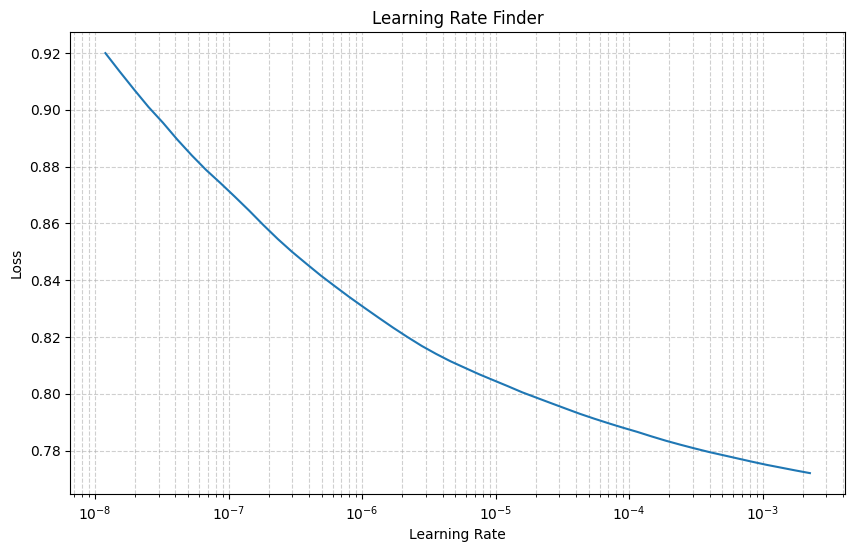

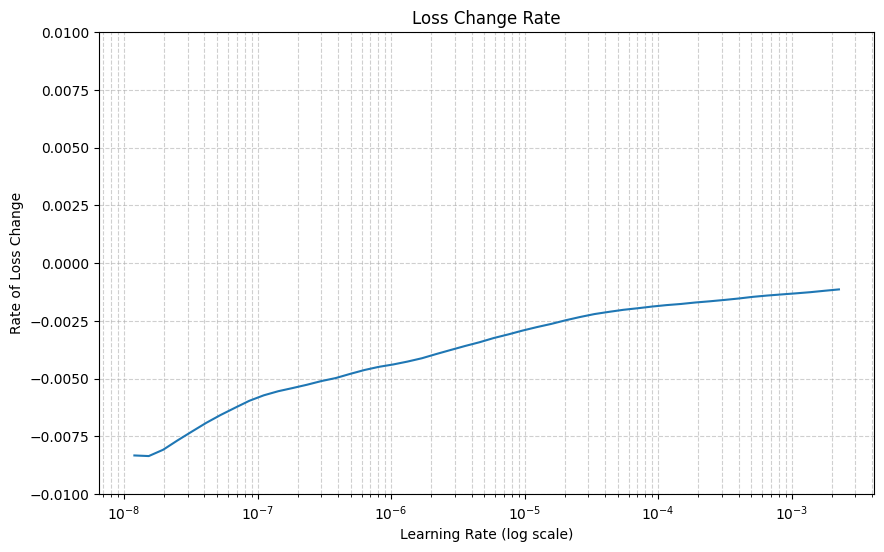

In [29]:
# Visualización
lr_finder.plot_loss()
lr_finder.plot_loss_change()

### One Cycle Policy

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [15]:
def one_cycle_scheduler(epoch, lr):
    total_epochs = epochs
    warmup_epochs = total_epochs // 4

    if epoch < warmup_epochs:  # Warmup
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / warmup_epochs)
    
    elif epoch < total_epochs - 5:  # Cosine annealing phase
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs - 5)))

    else:  # Final annealing phase
        return min_lr

### Training

In [ ]:
history, history_full = train_with_checkpoints(
    model_1,
    train_dataset,
    val_dataset,
    epochs=epochs,
    checkpoint_dir="checkpoints/i3d_model",
    one_cycle_scheduler=one_cycle_scheduler
)

Starting training from scratch.
Epoch 1/100


2025-04-10 00:42:40.519456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-10 00:42:50.843996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:43:00.368804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 119 of 516
2025-04-10 00:43:10.504340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-10 00:43:20.534813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-10 00:43:30.546355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-10 00:43:40.705857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 245 of 516
2025-04-10 00:43:50.771725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 277 of 516
2025-04-10 00:44:00.390153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 188s 558ms/step - loss: 1.0325 - accuracy: 0.5000 - val_loss: 1.0017 - val_accuracy: 0.5077
Epoch 2/100


2025-04-10 00:45:51.429342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-10 00:46:01.383132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:46:11.451425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-10 00:46:21.275835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 144 of 516
2025-04-10 00:46:31.285172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 175 of 516
2025-04-10 00:46:41.376456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 211 of 516
2025-04-10 00:46:51.305144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 240 of 516
2025-04-10 00:47:01.276990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 273 of 516
2025-04-10 00:47:11.373879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 194s 569ms/step - loss: 4.8835 - accuracy: 0.5058 - val_loss: 0.7204 - val_accuracy: 0.4923
Epoch 3/100


2025-04-10 00:49:08.666794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 516
2025-04-10 00:49:18.784658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 67 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:49:28.712755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 100 of 516
2025-04-10 00:49:38.937348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 132 of 516
2025-04-10 00:49:48.701096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 156 of 516
2025-04-10 00:49:58.712869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 184 of 516
2025-04-10 00:50:08.702173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-10 00:50:18.807474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 242 of 516
2025-04-10 00:50:28.874221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 212s 581ms/step - loss: 0.7023 - accuracy: 0.5078 - val_loss: 0.6793 - val_accuracy: 0.6000
Epoch 4/100


2025-04-10 00:52:44.341632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-10 00:52:53.827629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 69 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:53:04.074829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-10 00:53:14.386777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-10 00:53:24.075290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 158 of 516
2025-04-10 00:53:33.882558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 186 of 516
2025-04-10 00:53:43.965301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-10 00:53:54.096225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 244 of 516
2025-04-10 00:54:03.853937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 211s 573ms/step - loss: 0.7279 - accuracy: 0.5000 - val_loss: 0.7140 - val_accuracy: 0.4923
Epoch 5/100


2025-04-10 00:56:17.387725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-10 00:56:27.065896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:56:37.123349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-10 00:56:46.892899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-10 00:56:57.238848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-10 00:57:07.109124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-10 00:57:17.522507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-10 00:57:27.070249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-10 00:57:37.060260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 580ms/step - loss: 0.7070 - accuracy: 0.4651 - val_loss: 0.6894 - val_accuracy: 0.5077
Epoch 6/100


2025-04-10 00:59:48.101790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 32 of 516
2025-04-10 00:59:58.184550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 68 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 01:00:08.860092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-10 01:00:18.368003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 132 of 516
2025-04-10 01:00:28.234799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 156 of 516
2025-04-10 01:00:38.318448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 184 of 516
2025-04-10 01:00:48.404221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-10 01:00:58.170097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 240 of 516
2025-04-10 01:01:08.127574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 427s 1s/step - loss: 0.7107 - accuracy: 0.5349 - val_loss: 0.8768 - val_accuracy: 0.4923
Epoch 7/100


2025-04-10 01:06:56.762444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 516
2025-04-10 01:07:06.942809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 66 of 516
2025-04-10 01:07:19.336487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516
2025-04-10 01:07:27.154693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 87 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 01:07:36.948084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 105 of 516
2025-04-10 01:07:46.862741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-10 01:07:56.925551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-10 01:08:07.259719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-10 01:08:17.084933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-10 01:08:26.915369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-10 01:08:36.761783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 229s 574ms/step - loss: 0.7200 - accuracy: 0.4787 - val_loss: 0.7079 - val_accuracy: 0.5077
Epoch 8/100


2025-04-10 01:10:47.618522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-10 01:10:57.318407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 01:11:07.395327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-10 01:11:17.316948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-10 01:11:27.304331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-10 01:11:37.266076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 189 of 516
2025-04-10 01:11:47.644215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 218 of 516
2025-04-10 01:11:57.375019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 245 of 516
2025-04-10 01:12:07.324832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 573ms/step - loss: 0.7726 - accuracy: 0.4884 - val_loss: 0.7642 - val_accuracy: 0.5077
Epoch 9/100


2025-04-10 01:14:17.866998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-10 01:14:27.321331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 69 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 01:14:37.453451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-10 01:14:47.477014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-10 01:14:57.708054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-10 01:15:07.450962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-10 01:15:17.693209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-10 01:15:27.666520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-10 01:15:37.821367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 208s 572ms/step - loss: 0.7147 - accuracy: 0.5039 - val_loss: 0.7072 - val_accuracy: 0.5077
Epoch 10/100


2025-04-10 01:17:47.764940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-10 01:17:57.416243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 01:18:07.349129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-10 01:18:17.491202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-10 01:18:27.470378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-10 01:18:37.298979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 189 of 516
2025-04-10 01:18:47.400461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 218 of 516
2025-04-10 01:18:57.666115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-10 01:19:07.257850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 581ms/step - loss: 0.7172 - accuracy: 0.5291 - val_loss: 0.6941 - val_accuracy: 0.4923
Epoch 11/100


2025-04-10 01:21:18.635315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-10 01:21:28.069987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 69 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 01:21:38.220037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-10 01:21:48.465780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-10 01:21:58.084598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 158 of 516
2025-04-10 01:22:08.012280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 187 of 516
2025-04-10 01:22:18.146846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 217 of 516
2025-04-10 01:22:28.174943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 245 of 516
2025-04-10 01:22:38.171519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 571ms/step - loss: 0.7183 - accuracy: 0.4961 - val_loss: 0.7370 - val_accuracy: 0.4923
Epoch 12/100


2025-04-10 01:24:49.271265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-10 01:24:58.794202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 01:25:09.010607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-10 01:25:18.801261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-10 01:25:29.078048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-10 01:25:38.926409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-10 01:25:49.104861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-10 01:25:59.091857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-10 01:26:09.168309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 207s 567ms/step - loss: 0.7532 - accuracy: 0.4884 - val_loss: 0.7364 - val_accuracy: 0.4923
Epoch 13/100


2025-04-10 01:28:18.013655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-10 01:28:27.468832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 01:28:37.668740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-10 01:28:47.701150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-10 01:28:57.569560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-10 01:29:08.155665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-10 01:29:17.849392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-10 01:29:27.778100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-10 01:29:37.922064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 207s 561ms/step - loss: 0.7254 - accuracy: 0.5058 - val_loss: 0.6944 - val_accuracy: 0.5077
Epoch 14/100


2025-04-10 01:31:46.100815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-10 01:31:55.769334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 01:32:05.851659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-10 01:32:16.028324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-10 01:32:25.884093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 162 of 516
2025-04-10 01:32:35.940833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-10 01:32:46.454817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 221 of 516
2025-04-10 01:32:55.963690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-10 01:33:06.047560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 558ms/step - loss: 0.7300 - accuracy: 0.5155 - val_loss: 0.6988 - val_accuracy: 0.5077
Epoch 15/100


2025-04-10 01:35:12.589001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-10 01:35:22.350837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 01:35:32.238733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-10 01:35:42.508631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-10 01:35:52.262917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 158 of 516
2025-04-10 01:36:02.189692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 187 of 516
2025-04-10 01:36:12.165737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 216 of 516
2025-04-10 01:36:22.356603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 245 of 516
2025-04-10 01:36:32.358260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 207s 559ms/step - loss: 0.7820 - accuracy: 0.4961 - val_loss: 0.7670 - val_accuracy: 0.4923
Epoch 16/100


2025-04-10 01:38:40.723917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-10 01:38:50.474097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 01:39:00.683401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 105 of 516
2025-04-10 01:39:10.791387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 138 of 516
2025-04-10 01:39:20.691652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 163 of 516
2025-04-10 01:39:30.638100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 194 of 516
2025-04-10 01:39:40.566665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 221 of 516


### Evolución del Learning rate

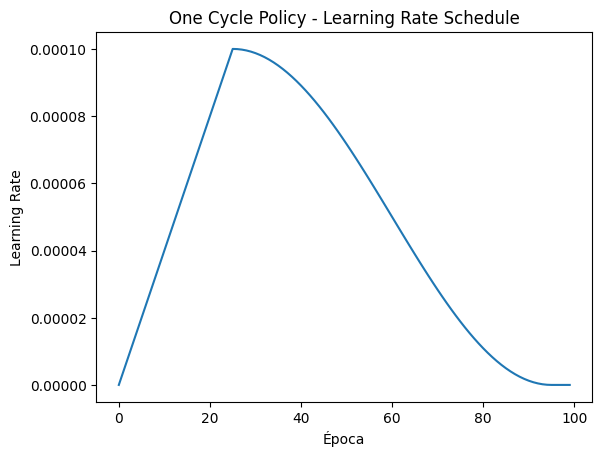

In [20]:
import matplotlib.pyplot as plt  # Corrección en la importación
min_lr = initial_learning_rate
max_lr = min_lr * 1000
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

In [ ]:
train_results = model_1.evaluate(train_dataset, verbose=1)

2025-04-09 19:28:06.340606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-09 19:28:16.284822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-09 19:28:26.407860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 119 of 516
2025-04-09 19:28:36.201487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 147 of 516
2025-04-09 19:28:46.787869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-09 19:28:56.632243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-09 19:29:06.535073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 245 of 516
2025-04-09 19:29:16.506506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 277 of 516
2025-04-09 19:29:26.246825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 159s 122ms/step - loss: 0.5432 - accuracy: 0.7597


In [ ]:
# Evaluar en el conjunto de validación
val_results = model_1.evaluate(val_dataset, verbose=1)

9/9 [==============================] - 18s 2s/step - loss: 0.5500 - accuracy: 0.7538


In [ ]:
# Evaluar en el conjunto de prueba
test_results = model_1.evaluate(test_dataset, verbose=1)

9/9 [==============================] - 20s 2s/step - loss: 0.6784 - accuracy: 0.6000


In [ ]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.5431685447692871, Accuracy: 0.7596899271011353
Val - Loss: 0.5500404834747314, Accuracy: 0.7538461685180664
Test - Loss: 0.6784451007843018, Accuracy: 0.6000000238418579


### Gráfica Epochs vs Loss

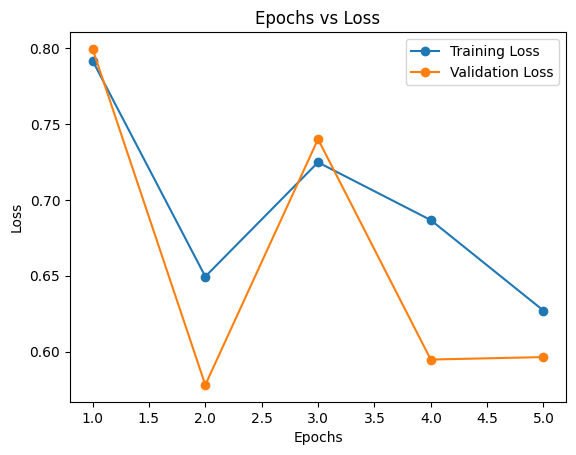

In [ ]:
import matplotlib.pyplot as plt
# Extraer la pérdida de entrenamiento y validación
loss = history_full['loss']
val_loss = history_full['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(False)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 65, Usando perplexity=10


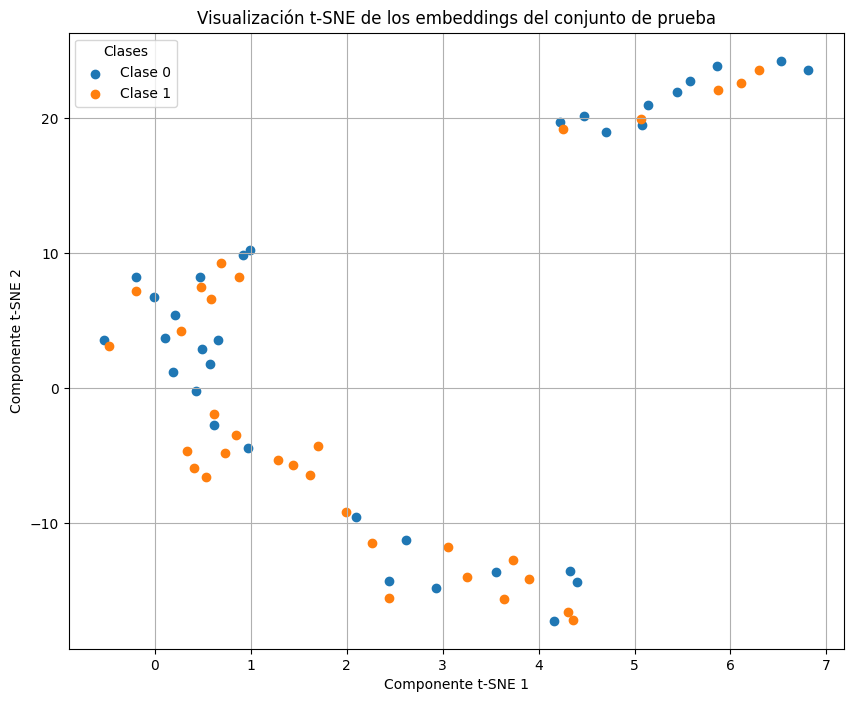

In [ ]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_1.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## I3D + ConvLSTM2D

In [ ]:
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, Dense, 
                                    Flatten, GlobalAveragePooling2D, 
                                    Dropout, BatchNormalization)
from tensorflow.keras import Model

class I3D_ConvLSTM(Model):
    def __init__(self, num_classes, endpoint="Mixed_5c"):
        super(I3D_ConvLSTM, self).__init__()
        np.random.seed(42)
        tf.random.set_seed(42)
        # Modelo base Inception I3D
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)
        
        # Capa ConvLSTM2D para modelar información temporal
        self.conv_lstm = ConvLSTM2D(
            filters=64, 
            kernel_size=(3, 3),
            padding='same',
            return_sequences=True,  # Mantener la dimensión temporal
            dropout=0.2,
            recurrent_dropout=0.2
        )
        
        # Batch Normalization después de ConvLSTM
        self.batch_norm = BatchNormalization()
        
        # Global Average Pooling para reducir dimensionalidad
        self.global_avg_pool = GlobalAveragePooling2D()  # Cambio a 2D
        
        # Dropout para regularización
        self.dropout = Dropout(0.3)
        
        # Capa completamente conectada final SIN activación (para logits)
        self.fc = Dense(num_classes)  # Eliminado activation='softmax'

    def call(self, inputs, training=False):
        """Entrada esperada: (batch_size, num_frames, height, width, channels)"""
        
        # Extraer características con I3D
        features, _ = self.i3d(inputs)  # (batch_size, num_frames, 7, 7, 1024)
        
        # Aplicar ConvLSTM2D sobre la dimensión temporal
        lstm_out = self.conv_lstm(features)  # (batch_size, num_frames, 7, 7, 64)
        
        # Tomar solo el último frame de la salida de LSTM para clasificación
        lstm_out = lstm_out[:, -1, :, :, :]  # (batch_size, 7, 7, 64)

        # Batch Normalization
        x = self.batch_norm(lstm_out, training=training)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Dropout para regularización
        x = self.dropout(x, training=training)
        
        # Capa de salida (ahora devuelve logits)
        logits = self.fc(x)
        
        return logits

In [ ]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

### Modelo

In [ ]:
epochs = 100  # Número de épocas
initial_learning_rate = 1e-7
num_classes = 2

In [ ]:
model_2 = I3D_ConvLSTM(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_2.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [ ]:
# Aplicar LR Finder en entrenamiento corto
lr_finder = LRFinder(start_lr=1e-7, end_lr=10, num_it=100)
for _ in range(5):  # Ejecutar varias veces para obtener mejores resultados
    model_2.fit(train_dataset, epochs=1, steps_per_epoch=100, callbacks=[lr_finder])

2025-04-10 00:07:43.038143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-10 00:07:53.371981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:08:02.964253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 119 of 516
2025-04-10 00:08:13.105008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-10 00:08:23.095701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-10 00:08:32.910355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-10 00:08:43.412599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-10 00:08:52.926216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 278 of 516
2025-04-10 00:09:03.064047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

  1/100 [..............................] - ETA: 4:35:43 - loss: 0.7799 - accuracy: 0.3750

2025-04-10 00:10:03.790609: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 182s 149ms/step - loss: 0.8092 - accuracy: 0.5194


2025-04-10 00:10:29.053853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-10 00:10:38.902050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:10:48.985697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 117 of 516
2025-04-10 00:10:58.856156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 146 of 516
2025-04-10 00:11:08.966897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-10 00:11:19.420271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-10 00:11:29.089872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 244 of 516
2025-04-10 00:11:38.907439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 275 of 516
2025-04-10 00:11:48.858330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

100/100 [==============================] - 168s 149ms/step - loss: 0.6607 - accuracy: 0.5814


2025-04-10 00:13:17.421632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-10 00:13:27.430209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:13:37.388449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 118 of 516
2025-04-10 00:13:47.354706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 147 of 516
2025-04-10 00:13:57.864547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-10 00:14:07.678892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-10 00:14:17.612744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 245 of 516
2025-04-10 00:14:27.515384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 277 of 516
2025-04-10 00:14:37.430298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

100/100 [==============================] - 166s 147ms/step - loss: 0.7660 - accuracy: 0.6066


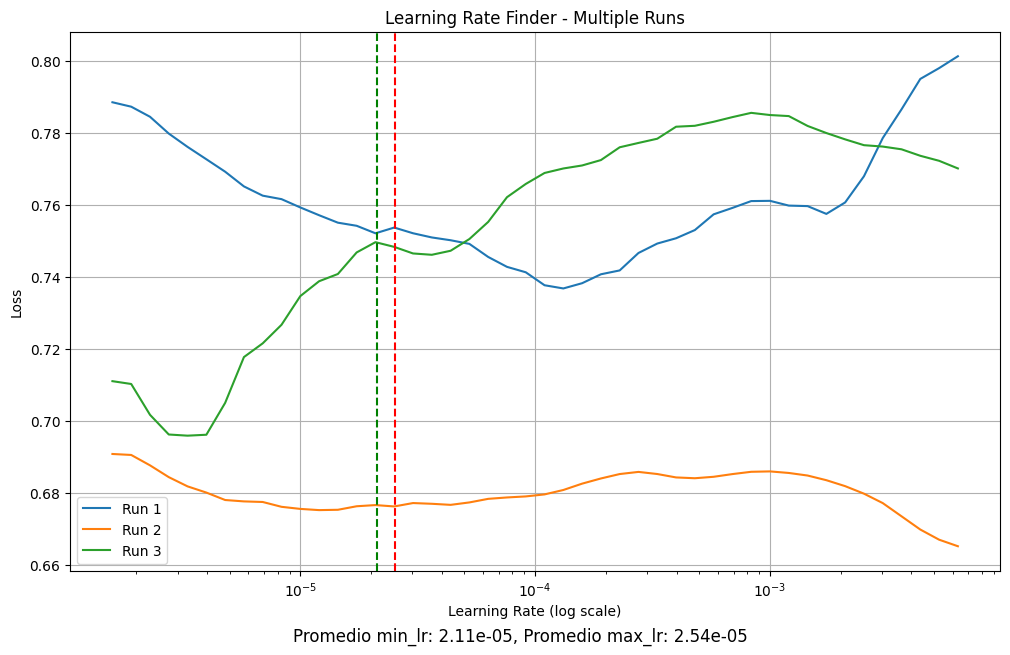

Promedio min_lr: 2.11e-05
Promedio max_lr: 2.54e-05


In [ ]:
# Obtener los valores óptimos de min_lr y max_lr
min_lr, max_lr = lr_finder.plot_all_runs()

In [ ]:
# Ajustar max_lr si es necesario
if abs(max_lr - min_lr) / min_lr < 100:
    max_lr = min_lr * 1000
print(f"min_lr: {min_lr}")
print(f"max_lr: {max_lr}")

999.0
min_lr: 2.1112062444980922e-05
max_lr: 0.02111206244498092


In [ ]:
def one_cycle_scheduler(epoch, lr):
    total_epochs = epochs
    warmup_epochs = total_epochs // 4

    if epoch < warmup_epochs:  # Warmup
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / warmup_epochs)
    
    elif epoch < total_epochs - 5:  # Cosine annealing phase
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs - 5)))

    else:  # Final annealing phase
        return min_lr

In [ ]:
history2, history_full2 = train_with_checkpoints(
    model_2,
    train_dataset,
    val_dataset,
    epochs=epochs,
    checkpoint_dir="checkpoints/i3d_convlstm",
    one_cycle_scheduler=one_cycle_scheduler
)

Starting training from scratch.
Epoch 1/2


2025-04-10 00:16:03.936945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-10 00:16:13.830521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 80 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:16:23.717079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-10 00:16:33.845223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 146 of 516
2025-04-10 00:16:44.027830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-10 00:16:53.941140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 213 of 516
2025-04-10 00:17:03.779672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 243 of 516
2025-04-10 00:17:13.799831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 275 of 516
2025-04-10 00:17:23.836297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 189s 562ms/step - loss: 0.6951 - accuracy: 0.5446 - val_loss: 0.6988 - val_accuracy: 0.4923
Epoch 2/2


2025-04-10 00:19:17.152102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-10 00:19:27.330292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:19:37.620690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 121 of 516
2025-04-10 00:19:47.172707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 149 of 516
2025-04-10 00:19:57.201047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 179 of 516
2025-04-10 00:20:07.391951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-10 00:20:17.219161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-10 00:20:27.185639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 280 of 516
2025-04-10 00:20:37.349930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 184s 516ms/step - loss: 0.6995 - accuracy: 0.5252 - val_loss: 0.6911 - val_accuracy: 0.5077


In [ ]:
train_results = model_2.evaluate(train_dataset, verbose=1)

2025-04-08 00:23:24.822227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-08 00:23:34.738983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 80 of 516
2025-04-08 00:23:44.768291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 118 of 516
2025-04-08 00:23:54.758586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 147 of 516
2025-04-08 00:24:04.735871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-08 00:24:15.207309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-08 00:24:25.096524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 161s 121ms/step - loss: 0.5442 - accuracy: 0.7287


In [ ]:
# Evaluar en el conjunto de validación
val_results = model_2.evaluate(val_dataset, verbose=1)

      3/Unknown - 7s 2s/step - loss: 0.3391 - accuracy: 0.9583

9/9 [==============================] - 18s 2s/step - loss: 0.5186 - accuracy: 0.8000


In [ ]:
# Evaluar en el conjunto de prueba
test_results = model_2.evaluate(test_dataset, verbose=1)

9/9 [==============================] - 20s 2s/step - loss: 0.6887 - accuracy: 0.5692


In [ ]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.5442267656326294, Accuracy: 0.7286821603775024
Val - Loss: 0.5185882449150085, Accuracy: 0.800000011920929
Test - Loss: 0.6710519194602966, Accuracy: 0.6615384817123413


### Evolución del Learning rate

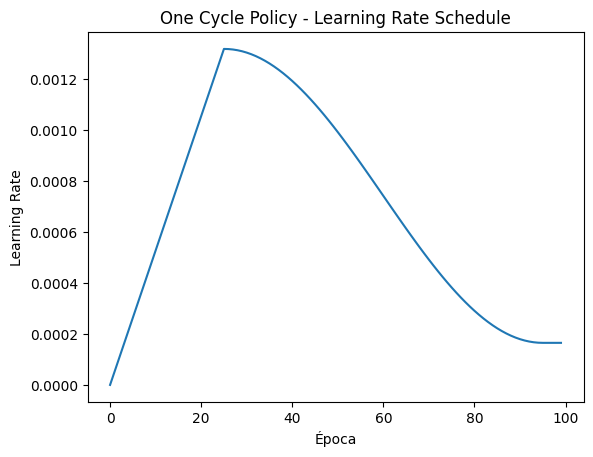

In [ ]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

### Gráfica Epochs vs Loss

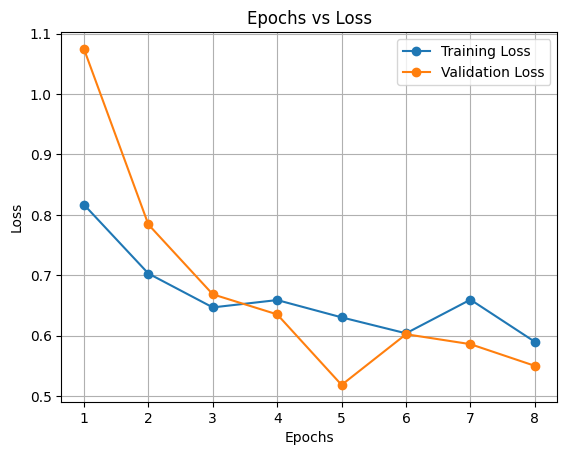

In [ ]:
import matplotlib.pyplot as plt

# Extraer la pérdida de entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 65, Usando perplexity=10


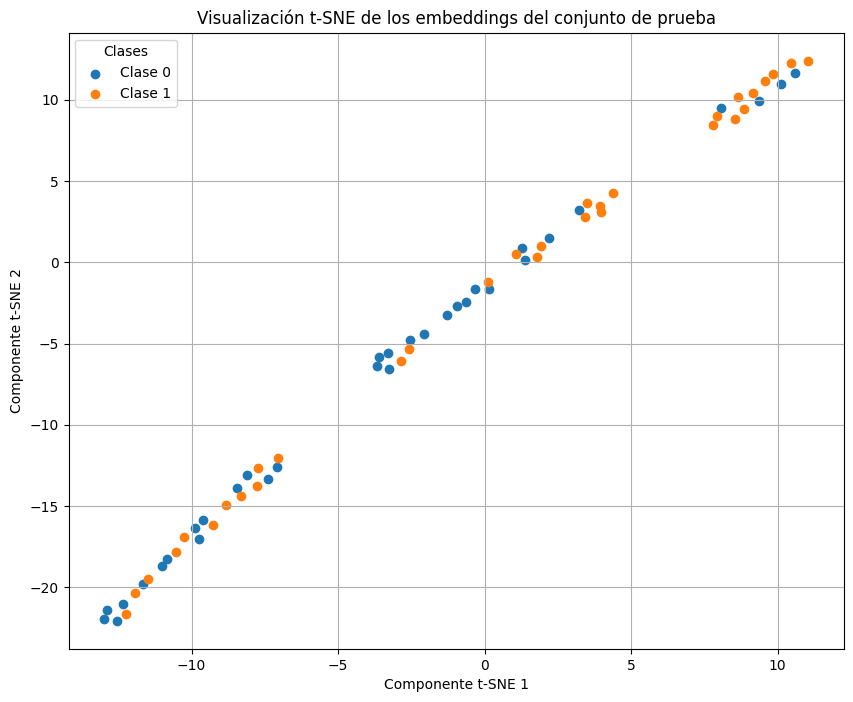

In [ ]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_2.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## Comparación de modelos

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('---------------------------------------------')
print("Modelo I3D")
# Obtener predicciones en el conjunto de prueba
y_pred = model_1.predict(test_dataset).argmax(axis=1)

# Obtener etiquetas reales del conjunto de prueba
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Convertir a numpy si es un tensor

# Imprimir el reporte de clasificación
print("Classification Report:\n", classification_report(y_true, y_pred))

# Imprimir la matriz de confusión
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

print('---------------------------------------------')
print("Modelo I3D+ConvLSTM")

# Obtener predicciones en el conjunto de prueba
y_pred = model_2.predict(test_dataset).argmax(axis=1)

# Obtener etiquetas reales del conjunto de prueba
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Convertir a numpy si es un tensor

# Imprimir el reporte de clasificación
print("Classification Report:\n", classification_report(y_true, y_pred))

# Imprimir la matriz de confusión
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

---------------------------------------------
Modelo I3D
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.45      0.48        33
           1       0.49      0.53      0.51        32

    accuracy                           0.49        65
   macro avg       0.49      0.49      0.49        65
weighted avg       0.49      0.49      0.49        65

Confusion Matrix:
 [[15 18]
 [15 17]]
---------------------------------------------
Modelo I3D+ConvLSTM
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.76      0.69        33
           1       0.69      0.56      0.62        32

    accuracy                           0.66        65
   macro avg       0.67      0.66      0.66        65
weighted avg       0.67      0.66      0.66        65

Confusion Matrix:
 [[25  8]
 [14 18]]
